## tensorflow tutorials RNN を使ったテキスト分類

tensorflowが2.0になってチュートリアルも新しくなりました。勉強がてら、すべてのチュートリアルを自分の環境で行ってみたいと思います。コードはほぼチュートリアルのコピーです。その中で気づいた部分や、注意すべき部分がこの記事の付加価値です。

- https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=ja

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

print('tf version     : ', tf.__version__)
print('keras version  : ', keras.__version__)
print('numpy version  : ',np.__version__)
print('pandas version : ',pd.__version__)
print('matlib version : ',matplotlib.__version__)

tf version     :  2.4.0
keras version  :  2.4.0
numpy version  :  1.19.4
pandas version :  1.0.3
matlib version :  3.0.3


## ヘルパー関数の作成
結果を描画するための関数

In [4]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 入力パイプラインの設定

IMDB映画レビューのデータセットは二値分類のデータセット。PositiveかNegativeの二択。TFDSを利用してダウンロード。

In [5]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

エンコードを含、任意の文字列を可逆的にエンコードする。

In [6]:
encoder = info.features['text'].encoder

In [7]:
'Vocabulary size: {}'.format(encoder.vocab_size)

'Vocabulary size: 8185'

In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [9]:
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## 訓練用データの準備

エンコード済み文字列をバッチ化する。padded_batchメソッドを利用して、バッチ中の一番長い文字列の長さにゼロパッディングする。

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## モデルの作成

Embeddingレイヤーの作成。単語一つに対して、一つのベクトルを収容する。呼び出しを受けると、Embeddingレイヤーは単語のインデックスのシーケンスをベクトルのシーケンスに変換する。

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size, 64),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## モデルの訓練

In [15]:
epochs = 10 # default
epochs = 1

history = model.fit(train_dataset, epochs=epochs,
                    validation_data=test_dataset, 
                    validation_steps=30)

391/391 [==============================] - 1046s 3s/step - loss: 0.6861 - accuracy: 0.5103 - val_loss: 0.4692 - val_accuracy: 0.8005


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 248s 636ms/step - loss: 0.4681 - accuracy: 0.8060
Test Loss: 0.4680662155151367
Test Accuracy: 0.8059599995613098


In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.20865834]]


In [20]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.32264385]]


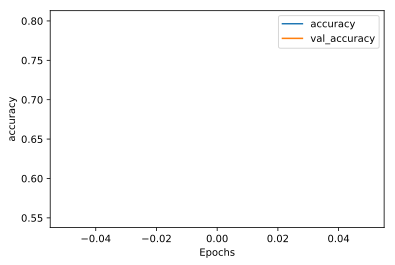

In [21]:
plot_graphs(history, 'accuracy')

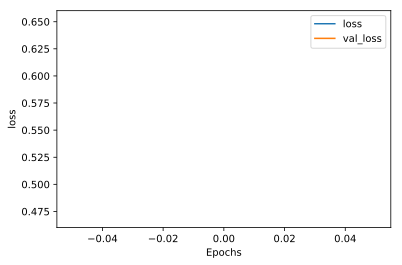

In [22]:
plot_graphs(history, 'loss')

## 2つ以上の LSTM レイヤー

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
    113/Unknown - 591s 5s/step - loss: 0.6932 - accuracy: 0.5022

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [ ]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')